# SingleCell Data Analysis on the GPU
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working rapids enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time
import os

import pandas as pd
import cudf
import cupy as cp
import sys

import rapids_singlecell as rsc

import matplotlib.pyplot as plt
from matplotlib import rcParams

sc.set_figure_params(dpi= 80, dpi_save = 300)
rcParams['figure.figsize'] = 5,5

In [2]:
import rmm
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)



## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/adata.raw.h5ad")

CPU times: user 1.97 s, sys: 126 ms, total: 2.1 s
Wall time: 2.1 s


In [5]:
adata.shape

(93575, 33694)

We now load the the AnnData object into a cunnData object. cunnData objects can be used as a replacement for scanpy and AnnData for the preprocessing. All functions are methods of the class.

In [6]:
%%time
cudata = rsc.cunnData.cunnData(adata=adata)

CPU times: user 1.56 s, sys: 752 ms, total: 2.31 s
Wall time: 2.31 s


Verify the shape of the resulting sparse matrix:

In [7]:
cudata.shape

(93575, 33694)

And the number of non-zero values in the matrix:

In [8]:
cudata.nnz

114212920

In [9]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 4.517963409423828


## Preprocessing

In [10]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [11]:
%%time
rsc.pp.flag_gene_family(cudata,gene_family_name="MT", gene_family_prefix="MT")

CPU times: user 4.29 ms, sys: 146 µs, total: 4.44 ms
Wall time: 4.38 ms


In [12]:
%%time
rsc.pp.flag_gene_family(cudata,gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 4.16 ms, sys: 0 ns, total: 4.16 ms
Wall time: 4.11 ms


In [13]:
%%time
rsc.pp.caluclate_qc(cudata,qc_vars=["MT","RIBO"])

CPU times: user 371 ms, sys: 59.2 ms, total: 430 ms
Wall time: 430 ms


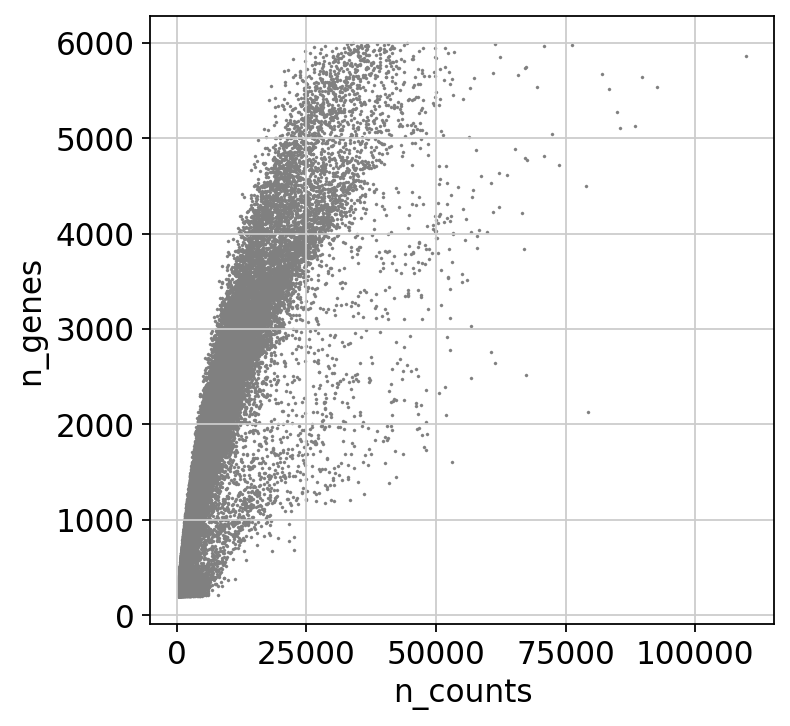

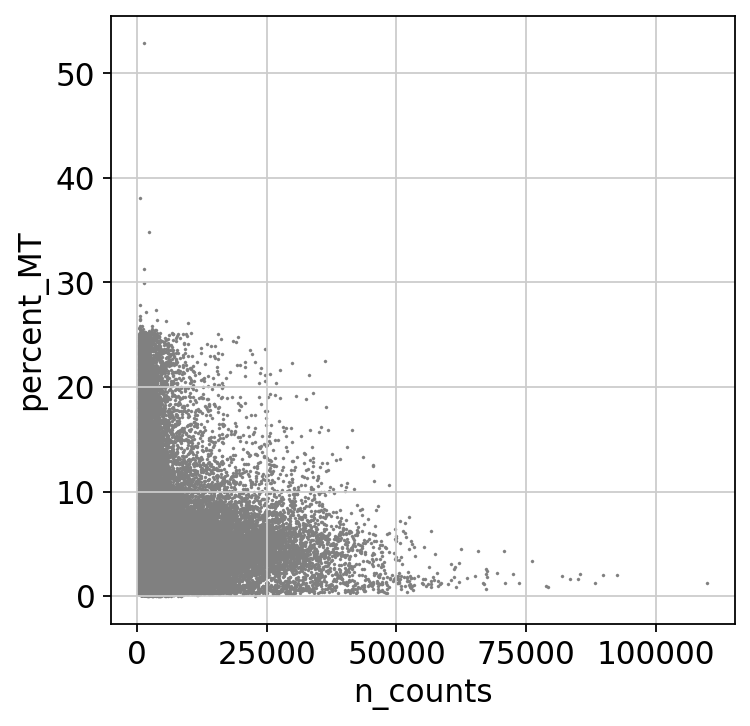

In [14]:
rsc.pp.plt_scatter(cudata,"n_counts","n_genes")
rsc.pp.plt_scatter(cudata,"n_counts","percent_MT")

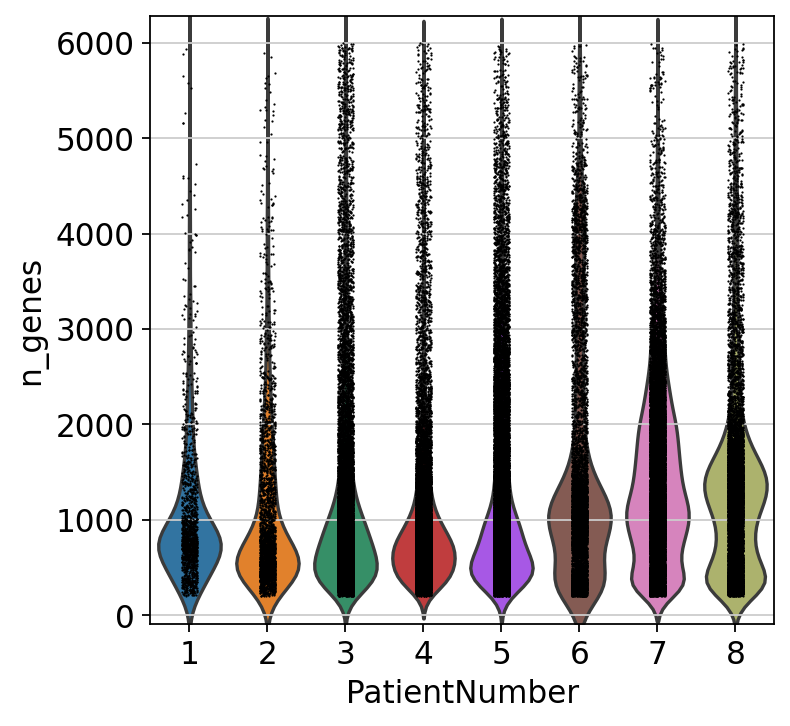

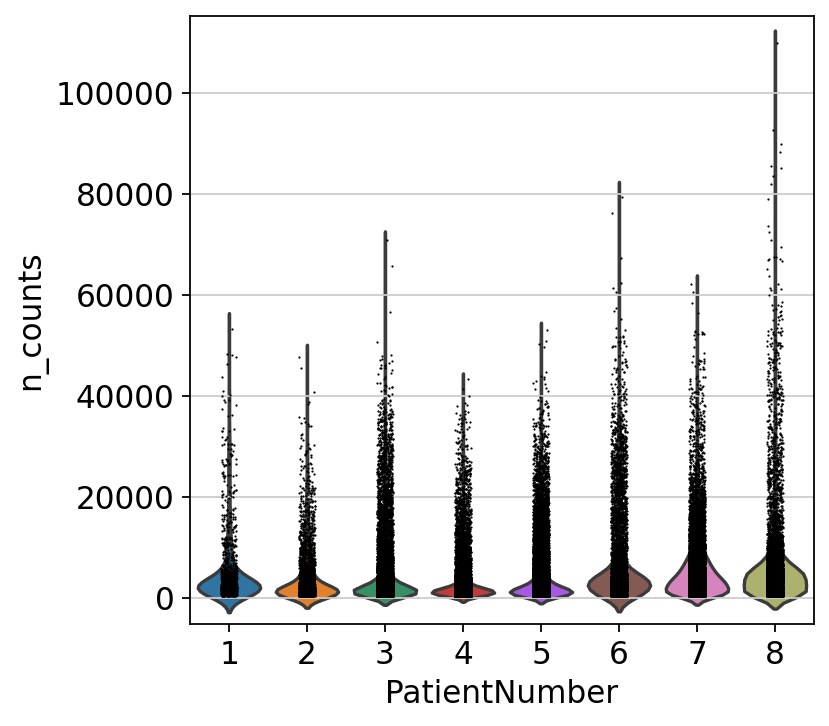

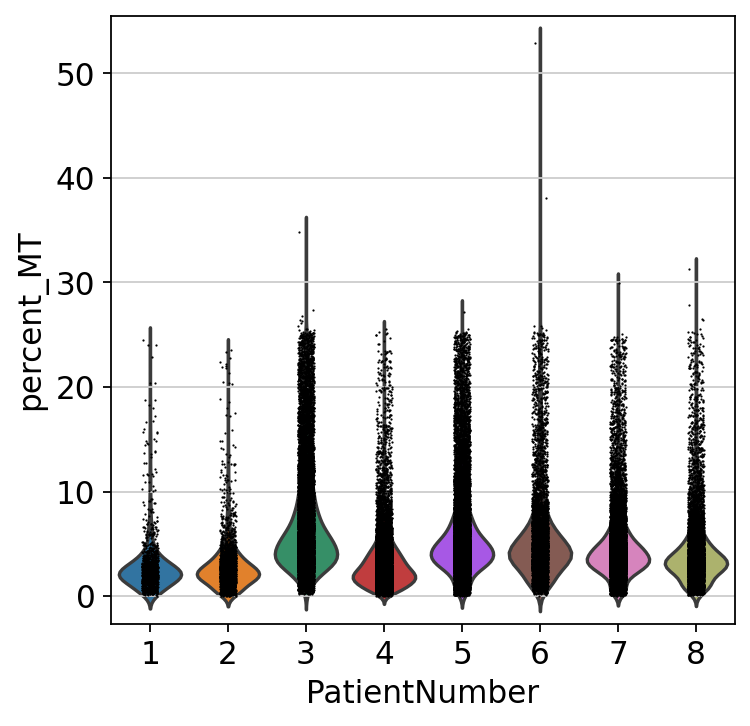

In [15]:
rsc.pp.plt_violin(cudata,key="n_genes",groupby="PatientNumber")
rsc.pp.plt_violin(cudata,key="n_counts",groupby="PatientNumber")
rsc.pp.plt_violin(cudata,key="percent_MT",groupby="PatientNumber")

We store the raw expression counts in the `.layer["counts"]`

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [16]:
%%time
cudata = cudata[cudata.obs["n_genes"] < 5000]
cudata = cudata[cudata.obs["percent_MT"] < 20]

CPU times: user 19.6 ms, sys: 7.55 ms, total: 27.2 ms
Wall time: 26.6 ms


In [17]:
cudata.layers["counts"] = cudata.X.copy()

n_samplesWe also filter out genes that are expressed in less than 3 cells.

In [18]:
%%time
rsc.pp.filter_genes(cudata,min_count=3)

filtered out 8034 genes based on n_cells
CPU times: user 127 ms, sys: 62.9 ms, total: 190 ms
Wall time: 189 ms


In [19]:
cudata.shape

(91068, 25660)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [20]:
%%time
rsc.pp.normalize_total(cudata,target_sum=1e4)

CPU times: user 275 µs, sys: 327 µs, total: 602 µs
Wall time: 466 µs


Next, we log transform the count matrix.

In [21]:
%%time
rsc.pp.log1p(cudata)

CPU times: user 0 ns, sys: 10.4 ms, total: 10.4 ms
Wall time: 10.1 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `seurat_v3` for selecting highly variable genes based on the raw counts in `.layer["counts"]`

In [22]:
%%time
rsc.pp.highly_variable_genes(cudata,n_top_genes=5000,flavor="seurat_v3",batch_key= "PatientNumber",layer = "counts")

CPU times: user 848 ms, sys: 1.89 s, total: 2.74 s
Wall time: 402 ms


Now we safe this verion of the cunndata object as an AnnData one. We'll use this as adata.raw later. 

In [23]:
%%time
bdata = cudata.to_AnnData()

CPU times: user 158 ms, sys: 105 ms, total: 263 ms
Wall time: 262 ms


Now we restrict our cunndata object to the highly variable genes.

In [24]:
%%time
cudata = cudata[:,cudata.var["highly_variable"]==True]

CPU times: user 97.6 ms, sys: 49 ms, total: 147 ms
Wall time: 146 ms


In [25]:
cudata.shape

(91068, 5000)

Next we regess out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [26]:
%%time
rsc.pp.regress_out(cudata,keys=["n_counts", "percent_MT"])

CPU times: user 920 ms, sys: 783 ms, total: 1.7 s
Wall time: 1.7 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [27]:
%%time
rsc.pp.scale(cudata,max_value=10)

CPU times: user 137 ms, sys: 0 ns, total: 137 ms
Wall time: 137 ms


Next we transfrom our cunnData object back to an AnnData object. We also set the normalized and logarithmized raw gene expression from bdata as adata.raw.

In [28]:
%%time
adata = cudata.to_AnnData()
adata.raw = bdata
del bdata, cudata

CPU times: user 257 ms, sys: 136 ms, total: 392 ms
Wall time: 391 ms


In [29]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 5.301742792129517


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from `scanpy_gpu_funcs` that uses cuMLs PCA to run this.

In [30]:
%%time
rsc.tl.pca(adata, n_comps = 100)

CPU times: user 1.32 s, sys: 469 ms, total: 1.79 s
Wall time: 1.79 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

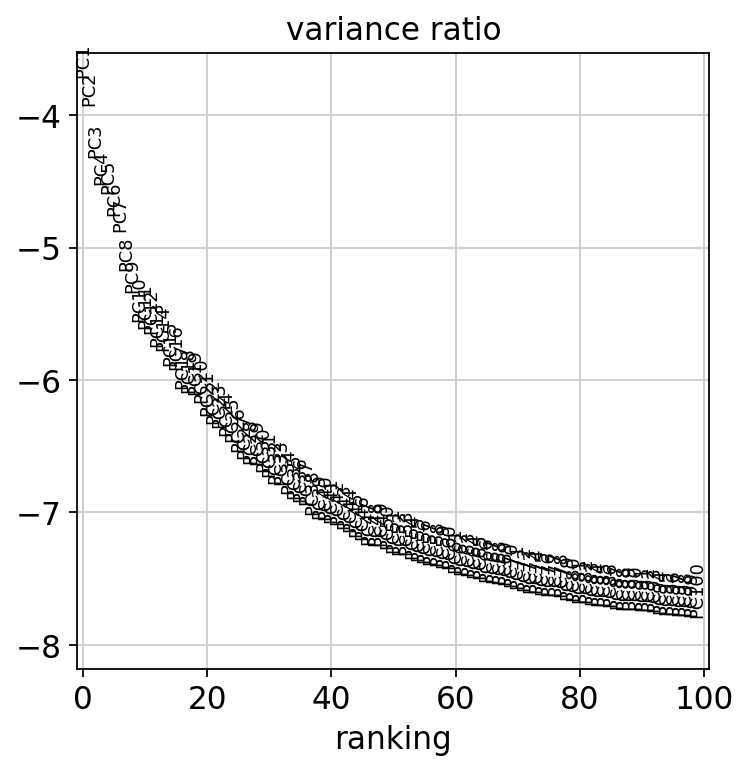

In [31]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using scanpy. Scanpy allready has so built in functions for GPU computing with rapids (`pp.neighbors`, `tl.umap` and `tl.louvain`). For `pp.neighbors` and `tl.umap` GPU computing can be invoked with `method='rapids'`.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [32]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40, method='rapids')

CPU times: user 4.57 s, sys: 62.2 ms, total: 4.63 s
Wall time: 4.63 s


Next we calculate the UMAP embedding using rapdis within scanpy.

In [33]:
%%time
sc.tl.umap(adata, method='rapids')

CPU times: user 381 ms, sys: 12.7 ms, total: 394 ms
Wall time: 393 ms


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering. As of the time of writing this notebook there is a known small bug in scanpy. The resoltion parameter of Louvain is not correctly passed to the cugraph funciton. This results in the resoltion beeing looked at 1.0.
Since the bug is fixed you can use `scanpy_gpu_funcs` implementation of Louvain.
Leiden clustering using Rapids has not been implemented in scanpy. You can also use `scanpy_gpu_funcs` implementation of the Leiden algorithm.

In [34]:
%%time
rsc.tl.louvain(adata, resolution=0.6)
#sc.tl.louvain(adata,flavor="rapids")

CPU times: user 314 ms, sys: 314 ms, total: 628 ms
Wall time: 628 ms


In [35]:
%%time
rsc.tl.leiden(adata,resolution=0.6)

CPU times: user 127 ms, sys: 18.6 ms, total: 146 ms
Wall time: 145 ms


/home/sdicks/miniconda3/envs/rapids-22.12a/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sdicks/miniconda3/envs/rapids-22.12a/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


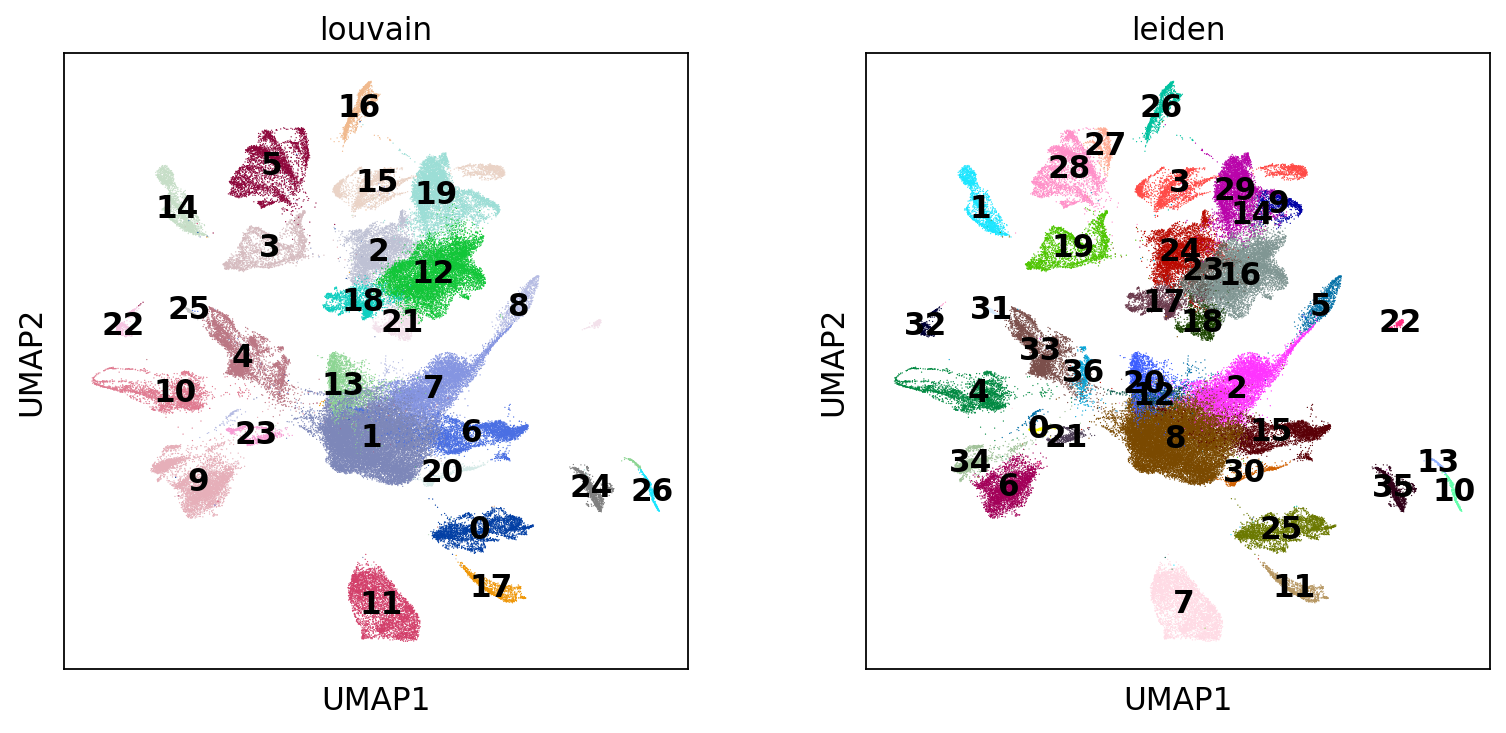

CPU times: user 622 ms, sys: 102 ms, total: 723 ms
Wall time: 565 ms


In [36]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

/home/sdicks/miniconda3/envs/rapids-22.12a/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sdicks/miniconda3/envs/rapids-22.12a/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


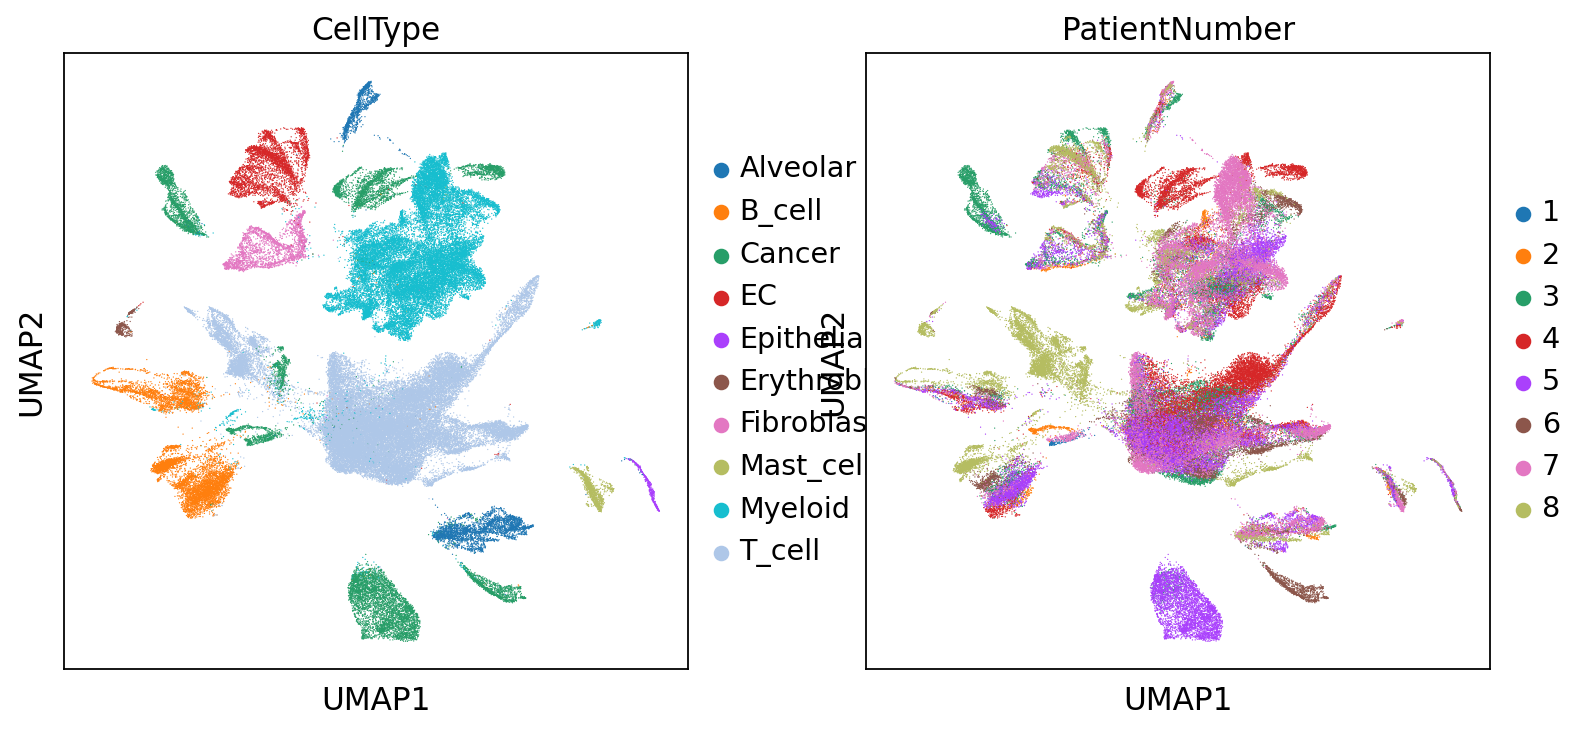

In [37]:
sc.pl.umap(adata, color= ["CellType", "PatientNumber"])

We also caluclate the embedding density in the UMAP using cuML

In [38]:
%%time
rsc.tl.embedding_density(adata, groupby="PatientNumber")

CPU times: user 692 ms, sys: 59.9 ms, total: 752 ms
Wall time: 751 ms


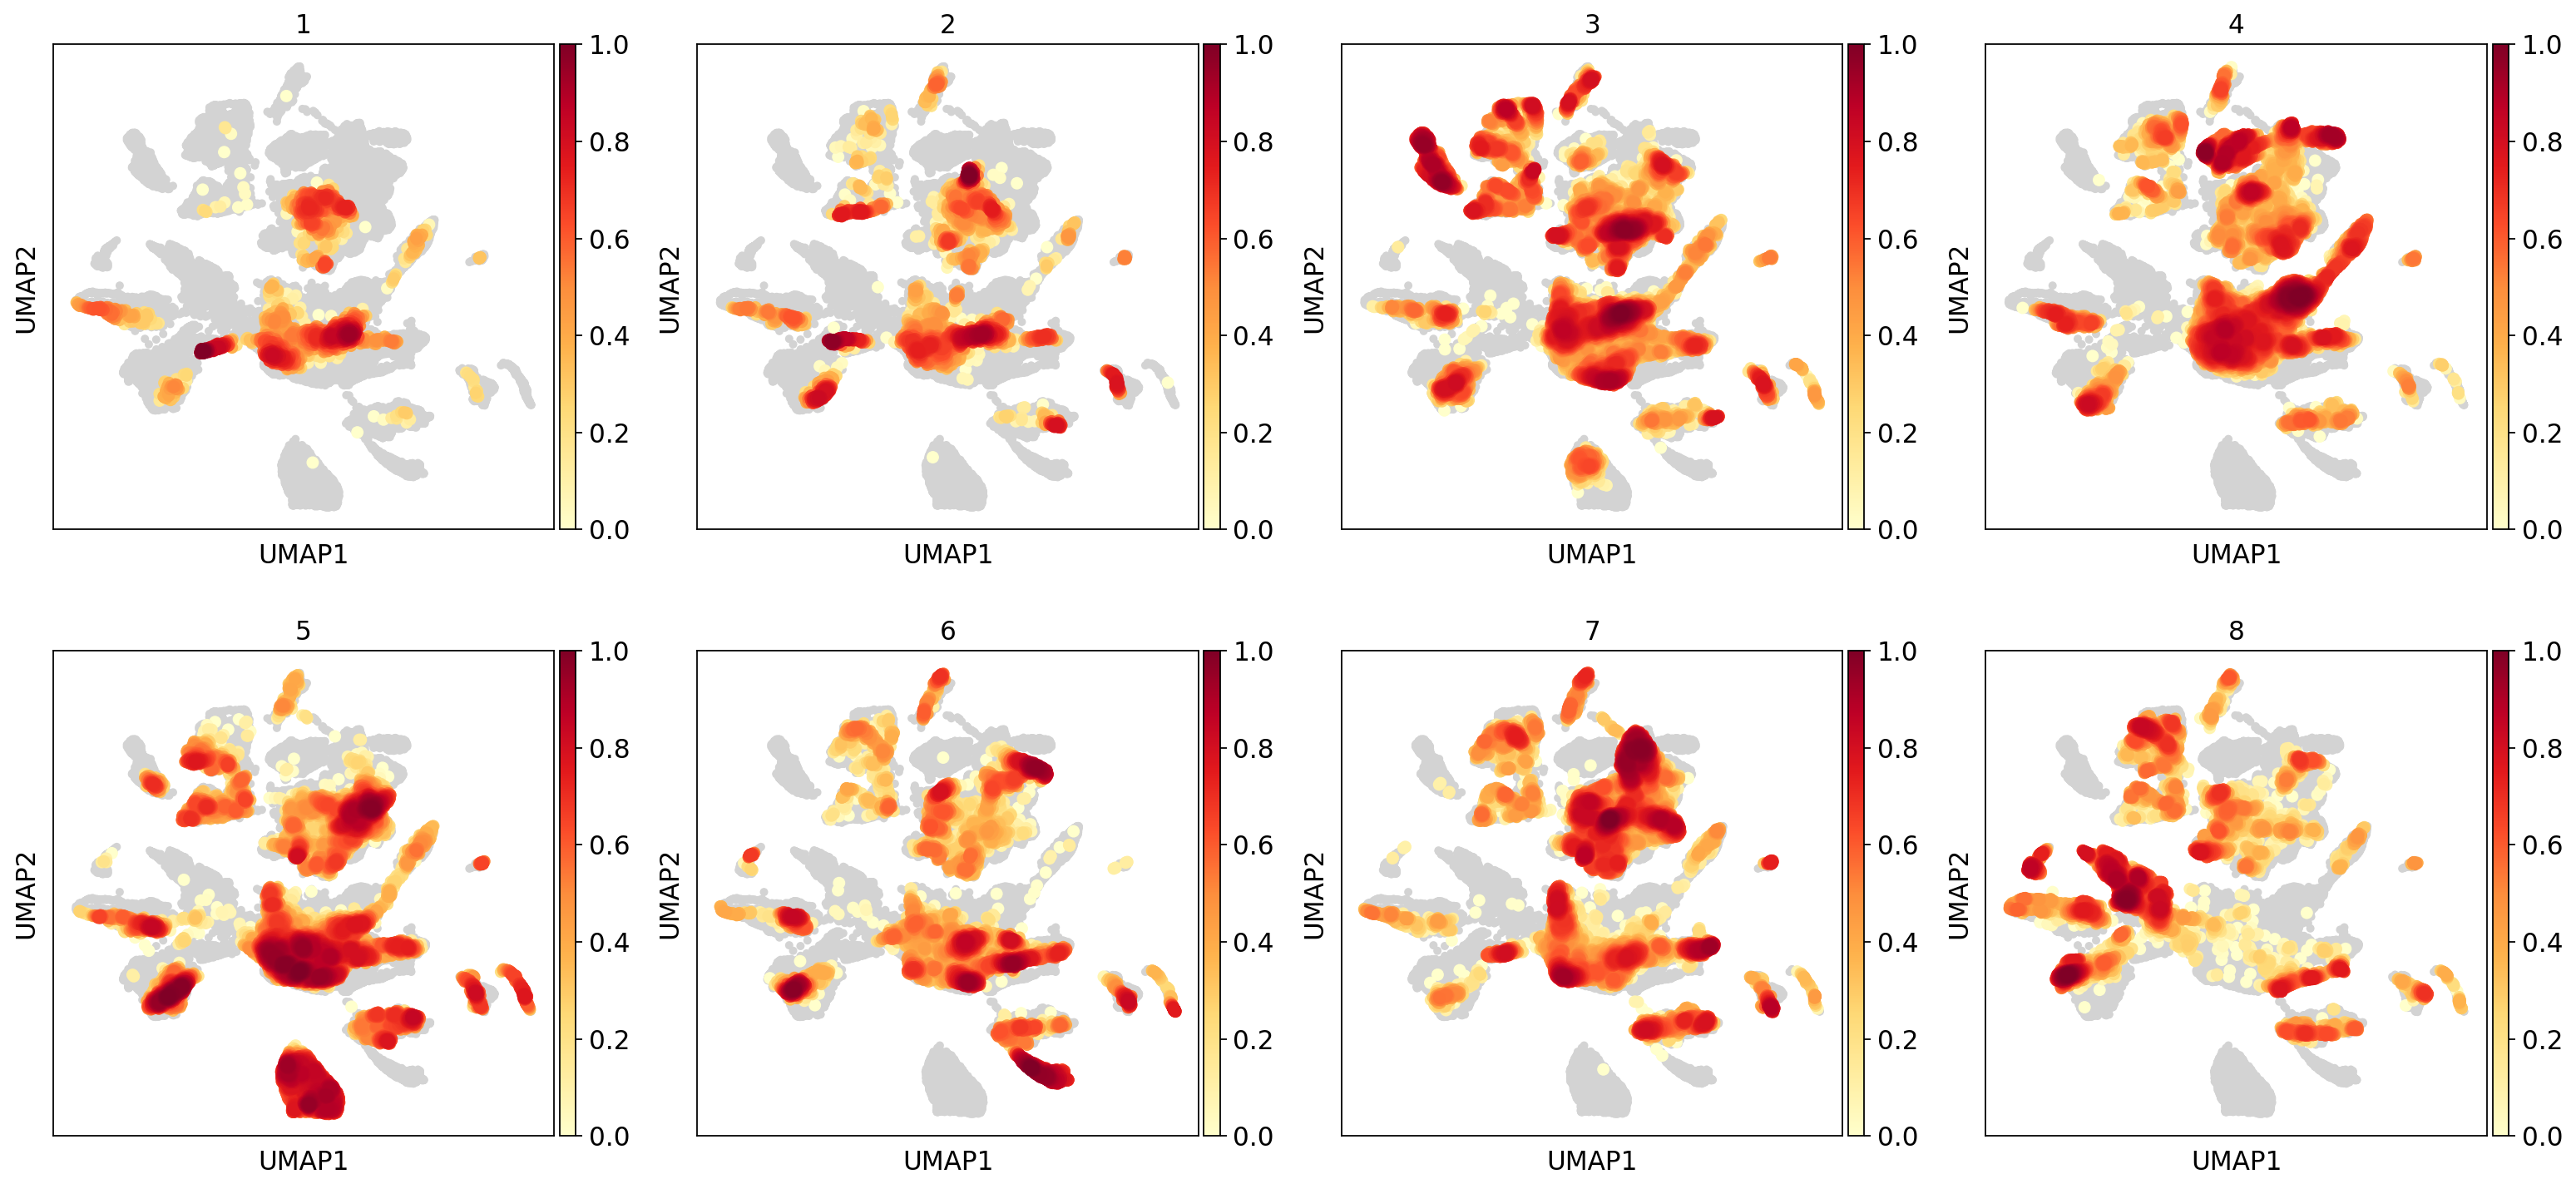

In [39]:
sc.pl.embedding_density(adata, groupby="PatientNumber")

### TSNE + k-Means

Next we use TSNE on the GPU to visualize the cells in two dimensions. We also perform k-Means clustering of the cells into 8 clusters.

In [40]:
%%time
rsc.tl.tsne(adata, n_pcs = 40)

/home/sdicks/miniconda3/envs/rapids-22.12a/lib/python3.9/site-packages/cuml/internals/api_decorators.py:794: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [14:34:57.851441] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 1.43 s, sys: 18.4 ms, total: 1.45 s
Wall time: 1.44 s


In [41]:
rsc.tl.kmeans(adata, n_clusters=8)

/home/sdicks/miniconda3/envs/rapids-22.12a/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


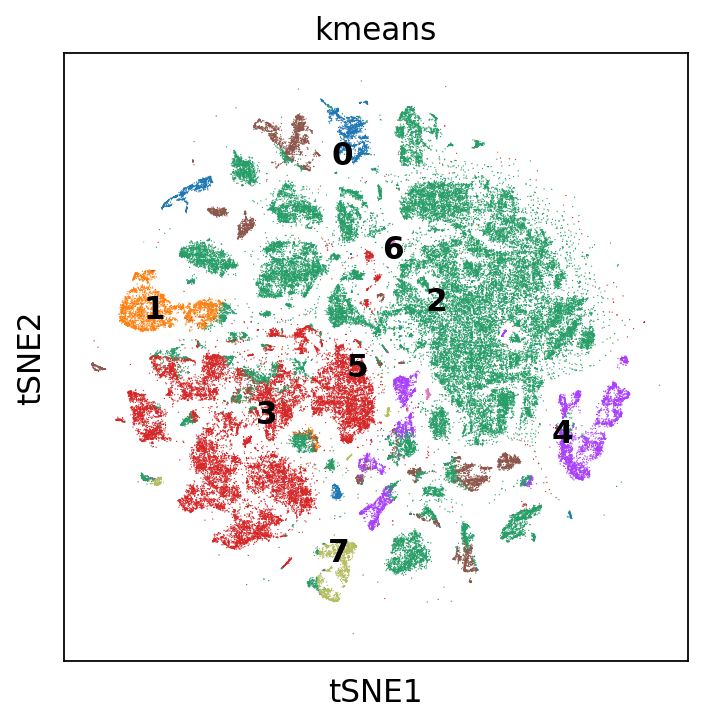

CPU times: user 339 ms, sys: 99.5 ms, total: 439 ms
Wall time: 280 ms


In [42]:
%%time
sc.pl.tsne(adata, color=["kmeans"],legend_loc = 'on data')

/home/sdicks/miniconda3/envs/rapids-22.12a/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sdicks/miniconda3/envs/rapids-22.12a/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


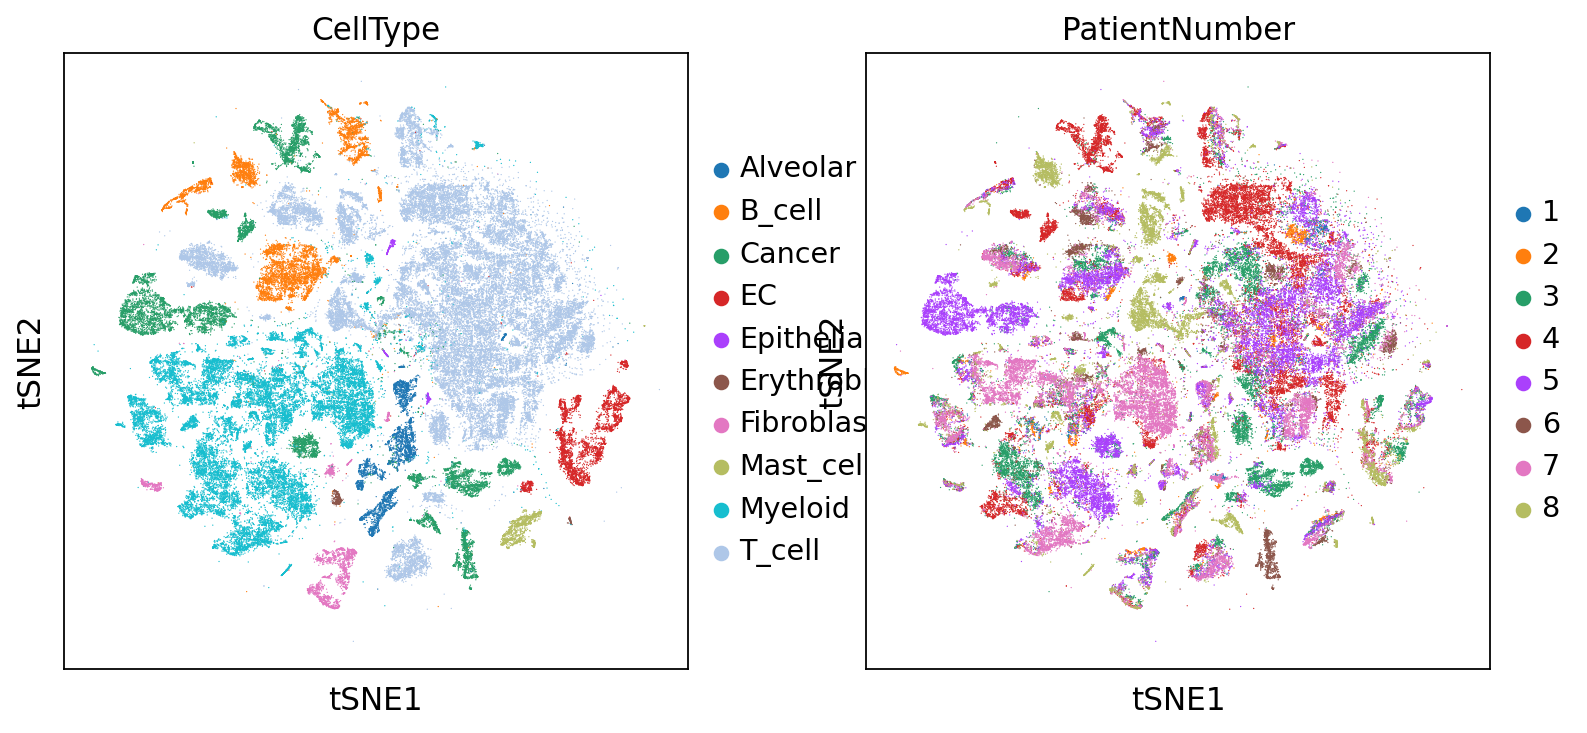

In [43]:
sc.pl.tsne(adata, color= ["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [44]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="CellType", use_raw=False)

CPU times: user 2.15 s, sys: 506 ms, total: 2.66 s
Wall time: 2.66 s


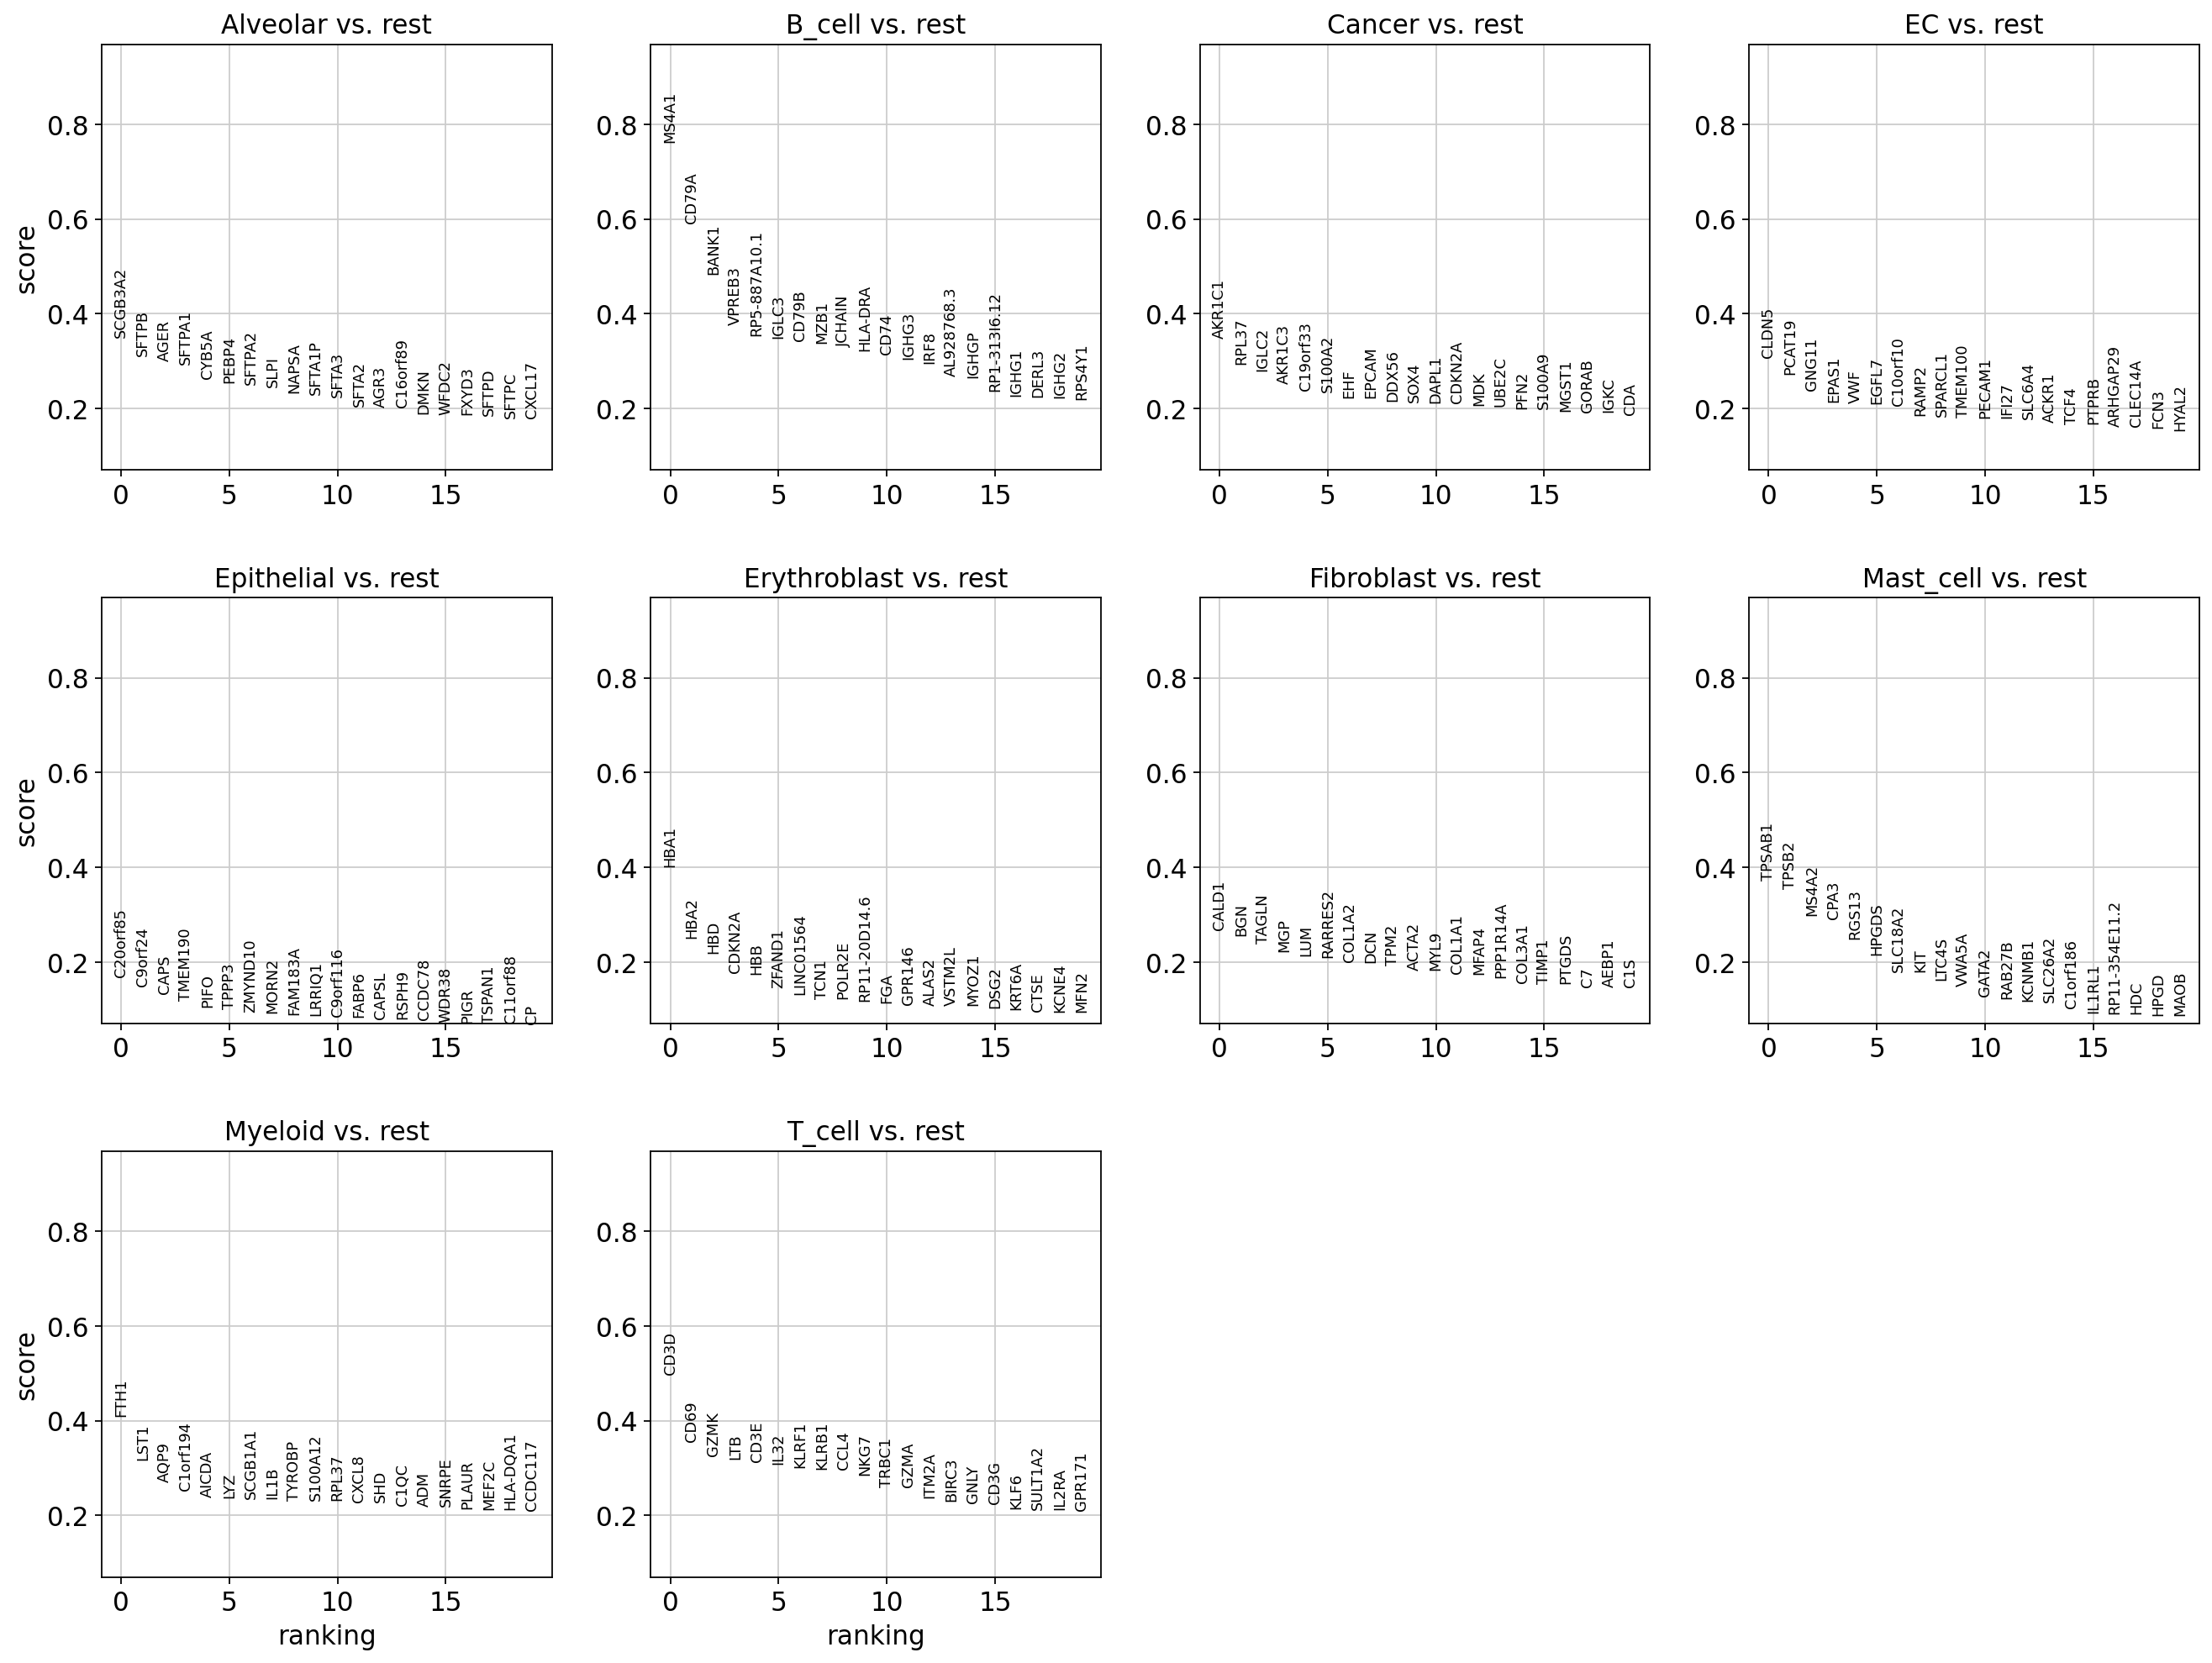

CPU times: user 780 ms, sys: 135 ms, total: 915 ms
Wall time: 754 ms


In [45]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [46]:
post_time = time.time()

In [47]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 18.447784185409546


## Diffusion Maps

With cupy 9 its possible to compute Eigenvalues of sparse matrixes. We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [48]:
tdata = adata[adata.obs["CellType"] == 'T_cell',:].copy()

We can repeat the dimension reduction, clustering and visulatization.

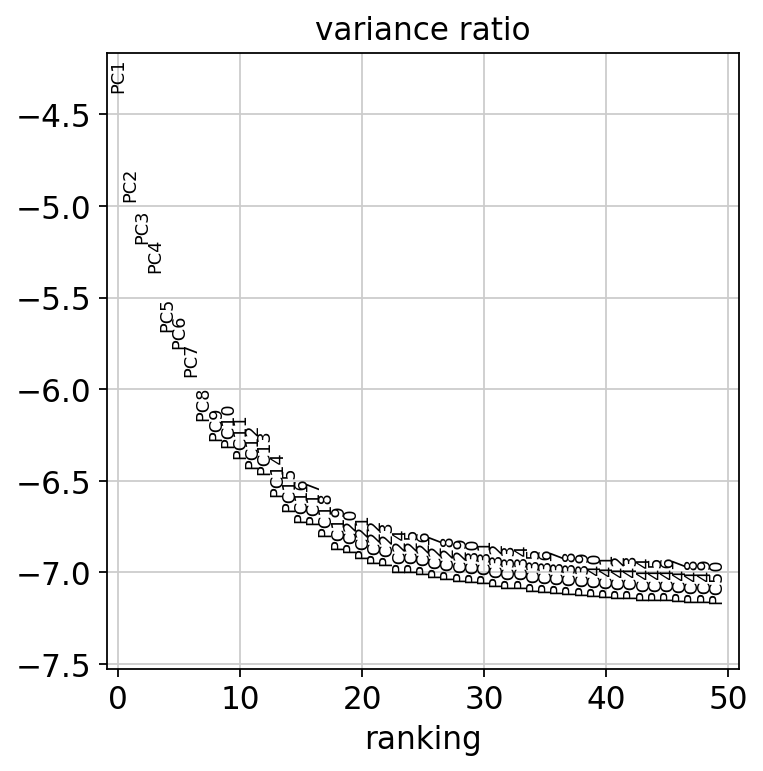

CPU times: user 885 ms, sys: 421 ms, total: 1.31 s
Wall time: 1.15 s


In [49]:
%%time
rsc.tl.pca(tdata,n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True,n_pcs=50)

In [50]:
%%time
sc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20, method='rapids')
sc.tl.umap(tdata, method='rapids')
rsc.tl.leiden(tdata)

CPU times: user 673 ms, sys: 64.4 ms, total: 737 ms
Wall time: 724 ms


/home/sdicks/miniconda3/envs/rapids-22.12a/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


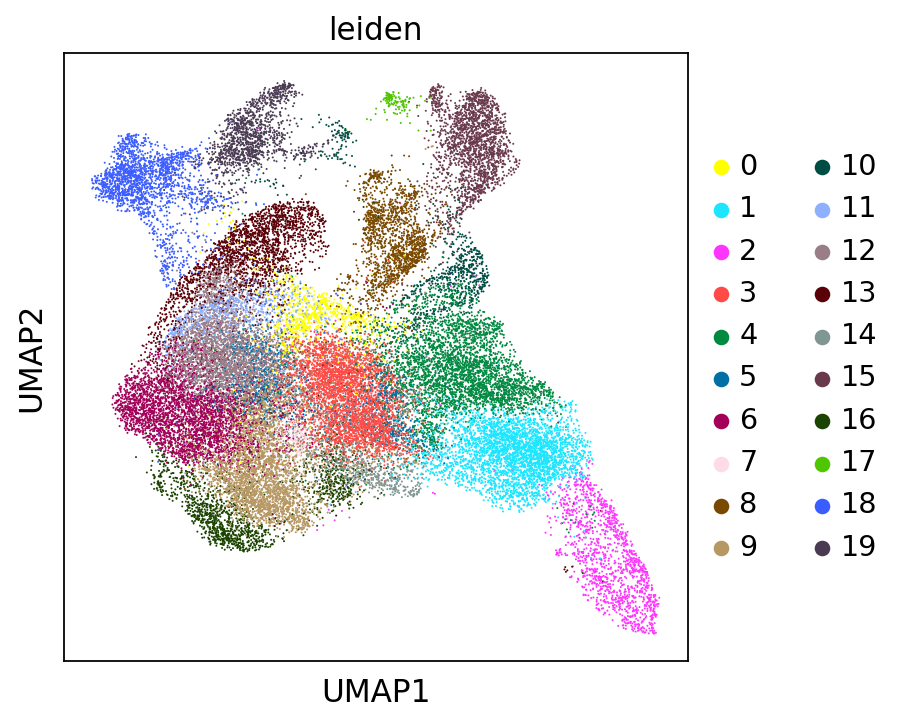

In [51]:
sc.pl.umap(tdata, color=["leiden"])

As stated before Diffusion Maps have become an integral part of single cell analysis. To run the computation with cupy 9, you can use `scanpy_gpu_funcs` implementation.

In [52]:
%%time
rsc.tl.diffmap(tdata)

CPU times: user 440 ms, sys: 772 ms, total: 1.21 s
Wall time: 181 ms


/home/sdicks/miniconda3/envs/rapids-22.12a/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


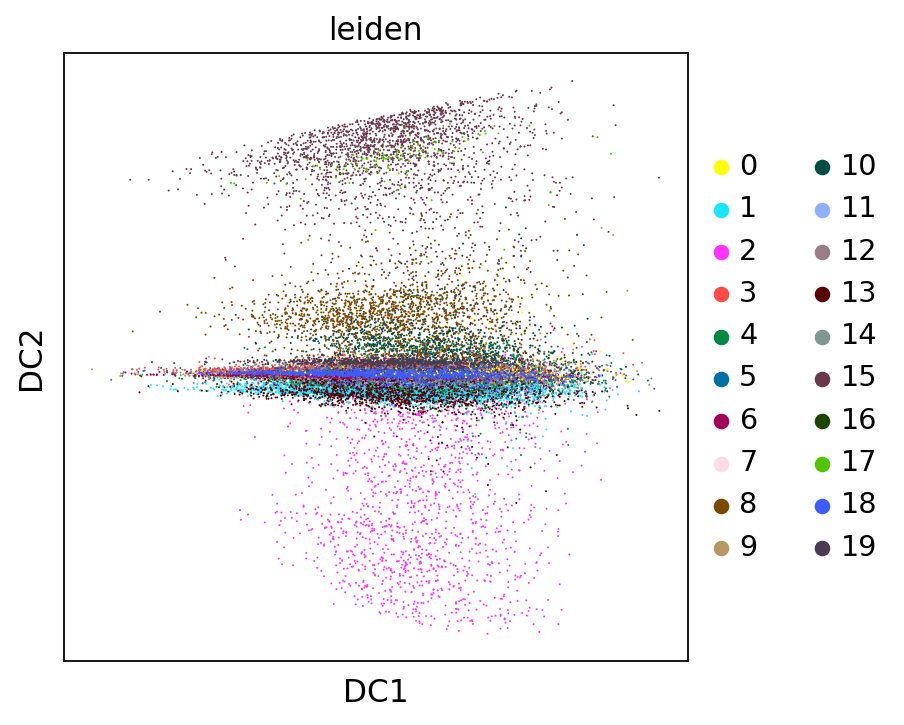

In [53]:
sc.pl.diffmap(tdata, color='leiden')

In [54]:
%%time
rsc.tl.draw_graph(tdata)

CPU times: user 268 ms, sys: 718 µs, total: 269 ms
Wall time: 268 ms


/home/sdicks/miniconda3/envs/rapids-22.12a/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


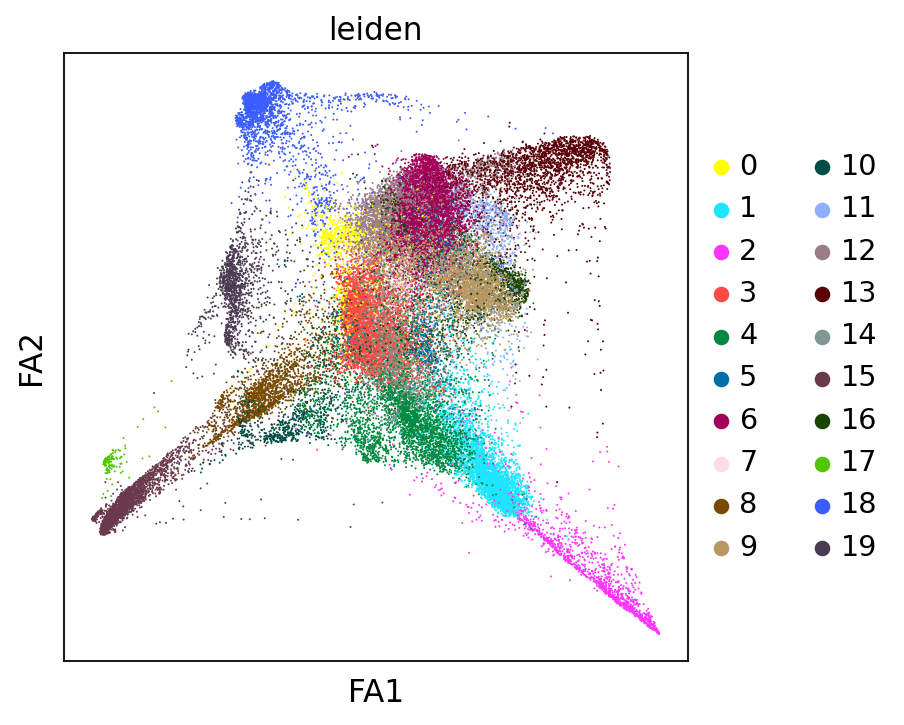

In [55]:
sc.pl.draw_graph(tdata, color='leiden')

After this you can use `X_diffmap` for `sc.pp.neighbors` and other fuctions. 

In [56]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 27.29860496520996
